In [2]:
import pandas as pd
import torch
from transformers import pipeline
from sklearn.preprocessing import StandardScaler
import openai
import time
import re

d:\Python 3.13.2\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


1.The main goal is to analyze the relationship between Bitcoin price movements and sentiment. It first loads Bitcoin price data and sentiment data, then analyzes the sentiment of the discussion text using the BERT pre-trained model and maps the sentiment score to [-1, 1]. Next, the code calculates the average daily sentiment score and analyzes the lagged correlation between the sentiment score and the change in the bitcoin price to explore whether sentiment has an impact on the bitcoin price in the coming days. Ultimately, the results are saved to merged_bitcoin_sentiment_data.csv for further analysis and research.

In [ ]:
# Load Data
bitcoin_path = "Final_Cleaned_Bitcoin_Data.csv"
sentiment_path = "Fully_Cleaned_Data.csv"

# Load Bitcoin data
bitcoin_data = pd.read_csv(bitcoin_path)
bitcoin_data["date"] = pd.to_datetime(bitcoin_data["Date"]).dt.date
bitcoin_data = bitcoin_data[["date", "Price Change", "Price Change %", "Trend"]]

# Load sentiment data
sentiment_data = pd.read_csv(sentiment_path)
sentiment_data["date"] = pd.to_datetime(sentiment_data["date"]).dt.date

# Perform Sentiment Analysis
sentiment_pipeline = pipeline("text-classification", model="nlptown/bert-base-multilingual-uncased-sentiment")

def get_sentiment_score(text):
    """Perform sentiment analysis using BERT and map scores to [-1, 1]."""
    if pd.isna(text) or not isinstance(text, str) or text.strip() == "":
        return None  # Handle empty or NaN values

    try:
        result = sentiment_pipeline(text)[0]
        label = int(result["label"][0])  # Extract rating (1-5)
    except:
        return None

    # Mapping rating: 1 (very negative) → -1.0, 5 (very positive) → 1.0
    sentiment_mapping = {1: -1.0, 2: -0.5, 3: 0.0, 4: 0.5, 5: 1.0}
    return sentiment_mapping.get(label, None)

# Apply sentiment analysis to data
sentiment_data["sentiment"] = sentiment_data["text"].apply(get_sentiment_score)
sentiment_data.dropna(subset=["sentiment"], inplace=True)

# Calculate Daily Average Sentiment Score
sentiment_data1 = sentiment_data.groupby("date")["sentiment"].mean().reset_index()

# Compute Lagged Correlation
def calculate_lagged_correlation(bitcoin_data, sentiment_data1, max_lag=7):
    merged_data = pd.merge(bitcoin_data, sentiment_data1, on="date", how="inner")
    correlations = {}

    for lag in range(1, max_lag + 1):
        merged_data[f"sentiment_lag_{lag}"] = merged_data["sentiment"].shift(lag)

        for col in ["Price Change", "Price Change %", "Trend"]:
            key = f"{col} - Lag {lag}"
            correlations[key] = merged_data[[col, f"sentiment_lag_{lag}"]].corr().iloc[0, 1]

    return correlations, merged_data

# Calculate lagged correlations (maximum lag of 5 days)
correlations, merged_data = calculate_lagged_correlation(bitcoin_data, sentiment_data1, max_lag=5)

# Output Results
print("Lagged correlation results:")
for key, corr in correlations.items():
    print(f"{key}: {corr}")

# Save merged data
merged_data.to_csv("merged_bitcoin_sentiment_data.csv", index=False)
print("Analysis complete, results saved to merged_bitcoin_sentiment_data.csv")


Device set to use cpu


Lagged correlation results:
Price Change - Lag 1: 0.12801630701176034
Price Change % - Lag 1: 0.12137922737383858
Trend - Lag 1: 0.19653803680304685
Price Change - Lag 2: -0.6417376789083845
Price Change % - Lag 2: -0.6403452955896484
Trend - Lag 2: -0.30134816158393324
Price Change - Lag 3: 0.4600215770608246
Price Change % - Lag 3: 0.46418302407576556
Trend - Lag 3: 0.7368622098573725
Price Change - Lag 4: -0.9384935910684827
Price Change % - Lag 4: -0.940635413918149
Trend - Lag 4: -0.6800599697964752
Price Change - Lag 5: 0.49483110108968614
Price Change % - Lag 5: 0.49625934284439155
Trend - Lag 5: 0.6850335234471369
Analysis complete, results saved to merged_bitcoin_sentiment_data.csv


visualize the outcome

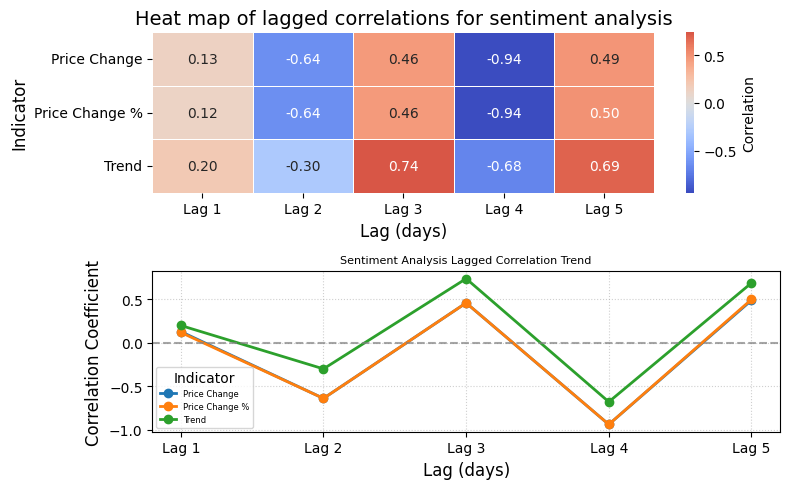

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#Result of the previous code box
correlation_data = {
    "Price Change": {
        "Lag 1": 0.13,
        "Lag 2": -0.64,
        "Lag 3": 0.46,
        "Lag 4": -0.94,
        "Lag 5": 0.49
    },
    "Price Change %": {
        "Lag 1": 0.12,
        "Lag 2": -0.64,
        "Lag 3": 0.46,
        "Lag 4": -0.94,
        "Lag 5": 0.50
    },
    "Trend": {
        "Lag 1": 0.20,
        "Lag 2": -0.30,
        "Lag 3": 0.74,
        "Lag 4": -0.68,
        "Lag 5": 0.69
    }
}

# Convert to DataFrame for easy plotting
df = pd.DataFrame(correlation_data)


plt.figure(figsize=(8, 5))

# 1. Heat map
plt.subplot(2, 1, 1)
sns.heatmap(df.T, annot=True, cmap='coolwarm', center=0, fmt='.2f', 
            linewidths=.5, cbar_kws={'label': 'Correlation'})
plt.title('Heat map of lagged correlations for sentiment analysis', fontsize=14) 
plt.xlabel('Lag (days)', fontsize=12) 
plt.ylabel('Indicator', fontsize=12)

# 2. Line Plot Demonstrate the trend of correlation with lag 
plt.subplot(2, 1, 2) 
for column in df.columns: 
 plt.plot(df. index, df[column], marker='o', linewidth=2, label=column) 

plt.axhline(y=0, color='gray', linestyle='--', alpha=0.7) 
plt.grid(True, linestyle=':', alpha=0.6)
plt.title('Sentiment Analysis Lagged Correlation Trend', fontsize=8) 
plt.xlabel('Lag (days)', fontsize=12) 
plt.ylabel('Correlation Coefficient', fontsize=12) 
plt. legend(title='Indicator',fontsize=6) 

plt.tight_layout() 
plt.savefig('lagged_correlation_visualization.png', dpi=300) 
plt.show()

In [16]:
sentiment_data["sentiment"].value_counts()
sentiment_data["sentiment"].describe()

count    386.000000
mean      -0.207254
std        0.782802
min       -1.000000
25%       -1.000000
50%       -0.500000
75%        0.500000
max        1.000000
Name: sentiment, dtype: float64

Demonstrating the Distribution of Sentiment Scores

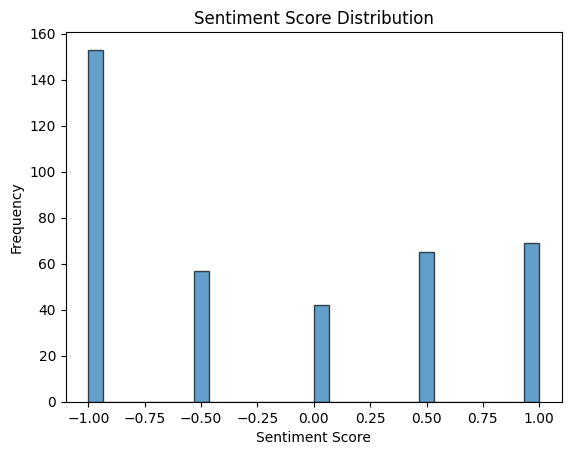

In [17]:
import matplotlib.pyplot as plt

plt.hist(sentiment_data["sentiment"], bins=30, edgecolor="black", alpha=0.7)
plt.xlabel("Sentiment Score")
plt.ylabel("Frequency")
plt.title("Sentiment Score Distribution")
plt.show()

In [ ]:
# set OpenAI API Key response = openai.chat.completions.create
openai.api_key = "API_key_here"

2.This code uses GPT-4o-mini to analyze the sentiment of Reddit discussion text and calculate the lagged correlation between it and bitcoin price changes. The code first loads the bitcoin price data and Reddit discussion data, ensures that the text field exists, and then calls GPT-4o-mini to categorize the sentiment (on a scale of 1-5) and map the scores to [-1, 1]. Next, the code calculates the average sentiment score for each day and analyzes its Pearson correlation with the Bitcoin price at different lags (1-5 days), and finally saves the results to merged_bitcoin_sentiment_data.csv for further analysis.

In [4]:
# Load Data
bitcoin_path = "Final_Cleaned_Bitcoin_Data.csv"
sentiment_path = "Fully_Cleaned_Data.csv"

import pandas as pd
import openai

# Load Bitcoin data
bitcoin_data = pd.read_csv(bitcoin_path)
bitcoin_data["date"] = pd.to_datetime(bitcoin_data["Date"]).dt.date
bitcoin_data = bitcoin_data[["date", "Price Change", "Price Change %", "Trend"]]

# Load sentiment data (ensure it includes a 'text' column)
sentiment_data = pd.read_csv(sentiment_path)
sentiment_data["date"] = pd.to_datetime(sentiment_data["date"]).dt.date

# Ensure 'text' column exists
if "text" not in sentiment_data.columns:
    raise ValueError("Error: 'text' column not found in Fully_Cleaned_Data.csv")

# Few-shot examples using the same format as the fine-tuning data
few_shot_examples = [
    {"role": "user", "content": "Minnesota Senator Proposes Bitcoin Act for Investments, Taxes and Retirement Plans."},
    {"role": "assistant", "content": "1.0"},
    
    {"role": "user", "content": "The recent regulatory approval of Bitcoin ETFs is a significant milestone for mainstream adoption."},
    {"role": "assistant", "content": "0.5"},
    
    {"role": "user", "content": "Strategy's Bitcoin Gambit Takes New Form With 'Perpetual'Stock."},
    {"role": "assistant", "content": "0.0"},
    
    {"role": "user", "content": "Bitcoin, Ethereum Face Uncertain Future: What Do Technical Indicators Say?"},
    {"role": "assistant", "content": "-0.5"},
    
    {"role": "user", "content": "The Hyperliquid whale who shorted Bitcoin (BTC) revealed X account, dismisses stolen funds narrative."},
    {"role": "assistant", "content": "-1.0"}
]

# Perform sentiment analysis with GPT-4o-mini using few-shot learning
def get_sentiment_score_gpt_fewshot(text):
    """ Call GPT-4o-mini to perform sentiment analysis with few-shot examples and print the API request and return results """
    if pd.isna(text) or not isinstance(text, str) or text.strip() == "":
        return None 

    # Create messages array starting with system message
    messages = [
        {"role": "system", "content": "You are a sentiment analysis assistant."}
    ]
    
    # Add few-shot examples
    for example in few_shot_examples:
        messages.append(example)
    
    # Add the text to analyze
    messages.append({"role": "user", "content": text})

    print(f"\n[API REQUEST] Sending API request to GPT-4o-mini with few-shot learning...")

    try:
        response = openai.chat.completions.create(
            model="ft:gpt-4o-mini-2024-07-18:personal::BCuRjGM7",
            messages=messages,
            temperature=0.3 # Maintaining consistency
        )

        # Parsing the API response
        sentiment_score_text = response.choices[0].message.content.strip()
        print(f"[API RESPONSE] GPT-4o Response: {sentiment_score_text}")  # Printing API Responses

        sentiment_score = float(sentiment_score_text)

    except Exception as e:
        print(f"[API ERROR] API Request Failed: {e}")
        return None  # Returns None on error

    return sentiment_score  # Return the sentiment score directly

# Apply GPT-4o-mini sentiment analysis with few-shot learning to data
print("\n[PROCESSING] Applying few-shot sentiment analysis to the dataset...")
sentiment_data["sentiment"] = sentiment_data["text"].apply(get_sentiment_score_gpt_fewshot)

sentiment_data.dropna(subset=["sentiment"], inplace=True)

# Compute daily average sentiment score
sentiment_data1 = sentiment_data.groupby("date")["sentiment"].mean().reset_index()

# Calculate Lagged Correlation
def calculate_lagged_correlation(bitcoin_data, sentiment_data1, max_lag=7):
    merged_data = pd.merge(bitcoin_data, sentiment_data1, on="date", how="inner")
    correlations = {}

    for lag in range(1, max_lag + 1):
        merged_data[f"sentiment_lag_{lag}"] = merged_data["sentiment"].shift(lag)

        for col in ["Price Change", "Price Change %", "Trend"]:
            key = f"{col} - Lag {lag}"
            correlations[key] = merged_data[[col, f"sentiment_lag_{lag}"]].corr().iloc[0, 1]

    return correlations, merged_data

# Calculate correlations (max lag of 5 days)
correlations, merged_data = calculate_lagged_correlation(bitcoin_data, sentiment_data1, max_lag=5)

# Output Results
print("\n [CORRELATION RESULTS] Lagged Correlation Analysis Results:")
for key, corr in correlations.items():
    print(f"{key}: {corr}")

# Save merged data
merged_data.to_csv("merged_bitcoin_sentiment_data_fewshot.csv", index=False)
print("\nAnalysis complete, results saved to merged_bitcoin_sentiment_data_fewshot.csv")

# Function to compare results between standard and few-shot approaches
def compare_results(original_file="merged_bitcoin_sentiment_data.csv", 
                   fewshot_file="merged_bitcoin_sentiment_data_fewshot.csv"):
    """Compare correlation results between standard and few-shot approaches"""
    try:
        original_data = pd.read_csv(original_file)
        fewshot_data = pd.read_csv(fewshot_file)
        
        print("\n[COMPARISON] Standard vs Few-Shot Learning Results:")
        
        # Calculate differences in sentiment scores
        common_dates = pd.merge(original_data, fewshot_data, on="date", how="inner")
        sentiment_diff = abs(common_dates["sentiment_x"] - common_dates["sentiment_y"]).mean()
        print(f"Average sentiment score difference: {sentiment_diff:.4f}")
        
        # Compare correlations
        for col in ["Price Change", "Price Change %", "Trend"]:
            for lag in range(1, 6):
                lag_col = f"sentiment_lag_{lag}"
                if lag_col in original_data.columns and lag_col in fewshot_data.columns:
                    orig_corr = original_data[[col, lag_col]].corr().iloc[0, 1]
                    fewshot_corr = fewshot_data[[col, lag_col]].corr().iloc[0, 1]
                    diff = fewshot_corr - orig_corr
                    print(f"{col} - Lag {lag}: Standard={orig_corr:.4f}, Few-Shot={fewshot_corr:.4f}, Diff={diff:.4f}")
        
    except Exception as e:
        print(f"[COMPARISON] Could not compare results: {e}")



[PROCESSING] Applying few-shot sentiment analysis to the dataset...

[API REQUEST] Sending API request to GPT-4o-mini with few-shot learning...
[API RESPONSE] GPT-4o Response: 0.5

[API REQUEST] Sending API request to GPT-4o-mini with few-shot learning...
[API RESPONSE] GPT-4o Response: 0.5

[API REQUEST] Sending API request to GPT-4o-mini with few-shot learning...
[API RESPONSE] GPT-4o Response: 0.0

[API REQUEST] Sending API request to GPT-4o-mini with few-shot learning...
[API RESPONSE] GPT-4o Response: -0.5

[API REQUEST] Sending API request to GPT-4o-mini with few-shot learning...
[API RESPONSE] GPT-4o Response: -1.0

[API REQUEST] Sending API request to GPT-4o-mini with few-shot learning...
[API RESPONSE] GPT-4o Response: 0.5

[API REQUEST] Sending API request to GPT-4o-mini with few-shot learning...
[API RESPONSE] GPT-4o Response: 1.0

[API REQUEST] Sending API request to GPT-4o-mini with few-shot learning...
[API RESPONSE] GPT-4o Response: 0.5

[API REQUEST] Sending API reques

The code prints the first 10 discussion texts and their corresponding sentiment scores, then asks the user to enter a maximum lag (max_lag), from which it calculates the lagged correlation between sentiment and the bitcoin price, and prints the correlation values for different lags. Finally, it saves the merged data as merged_bitcoin_sentiment_data.csv for further analysis.

In [5]:
print(sentiment_data[["text", "sentiment"]].head(10))

max_lag = int(input("Please enter the maximum number of days lag: "))

correlations, merged_data = calculate_lagged_correlation(bitcoin_data, sentiment_data1, max_lag)
    
print("Lagged correlation results:")
for lag, corr in correlations.items():
    print(f"{lag}: {corr}")
    
merged_data.to_csv("merged_bitcoin_sentiment_data.csv", index=False)
print("The analysis is complete and the results have been saved as merged_bitcoin_sentiment_data.csv")


                                                text  sentiment
0  Grayscale CEO Michael Sonnenshein believes the...        0.5
1  In an exclusive interview with CryptoNews, Man...        0.5
2  According to the Federal Court ruling on Decem...        0.0
3  Some suggest EVM inscriptions are the latest w...       -0.5
4  A decision by bloXroute Labs to start censorin...       -1.0
5  Yonsei found that during BTCâs rally in earl...        0.5
6  Cathie Wood led ARK Invest fund sold around 80...        1.0
7  Bitcoin's 150% surge pales in comparison to th...        0.5
8  The South Korean city of Busan is edging close...        1.0
9  The SEC has pushed back its decision on a rost...        0.5
Lagged correlation results:
Price Change - Lag 1: 0.4447171402837128
Price Change % - Lag 1: 0.44049910583587093
Trend - Lag 1: 0.4462209389693631
Price Change - Lag 2: -0.4909473763120962
Price Change % - Lag 2: -0.49138407927477007
Trend - Lag 2: -0.10791952977749891
Price Change - Lag 3: 0.01

The following code is for visualization 

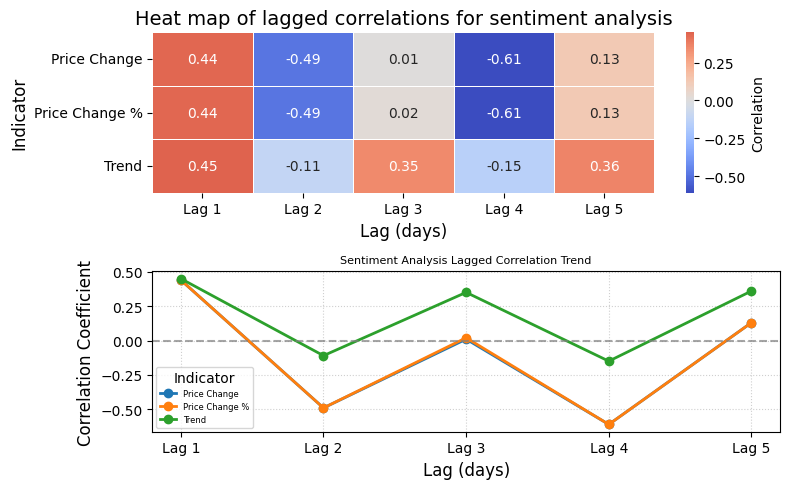

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#Result of the previous code box
correlation_data = {
    "Price Change": {
        "Lag 1": 0.44,
        "Lag 2": -0.49,
        "Lag 3": 0.01,
        "Lag 4": -0.61,
        "Lag 5": 0.13
    },
    "Price Change %": {
        "Lag 1": 0.44,
        "Lag 2": -0.49,
        "Lag 3": 0.02,
        "Lag 4": -0.61,
        "Lag 5": 0.13
    },
    "Trend": {
        "Lag 1": 0.45,
        "Lag 2": -0.11,
        "Lag 3": 0.35,
        "Lag 4": -0.15,
        "Lag 5": 0.36
    }
}

# Convert to DataFrame for easy plotting
df = pd.DataFrame(correlation_data)


plt.figure(figsize=(8, 5))

# 1. Heat map
plt.subplot(2, 1, 1)
sns.heatmap(df.T, annot=True, cmap='coolwarm', center=0, fmt='.2f', 
            linewidths=.5, cbar_kws={'label': 'Correlation'})
plt.title('Heat map of lagged correlations for sentiment analysis', fontsize=14) 
plt.xlabel('Lag (days)', fontsize=12) 
plt.ylabel('Indicator', fontsize=12)

# 2. Line Plot Demonstrate the trend of correlation with lag 
plt.subplot(2, 1, 2) 
for column in df.columns: 
 plt.plot(df. index, df[column], marker='o', linewidth=2, label=column) 

plt.axhline(y=0, color='gray', linestyle='--', alpha=0.7) 
plt.grid(True, linestyle=':', alpha=0.6)
plt.title('Sentiment Analysis Lagged Correlation Trend', fontsize=8) 
plt.xlabel('Lag (days)', fontsize=12) 
plt.ylabel('Correlation Coefficient', fontsize=12) 
plt. legend(title='Indicator',fontsize=6) 

plt.tight_layout() 
plt.savefig('lagged_correlation_visualization.png', dpi=300) 
plt.show()

This code counts and visualizes the distribution of sentiment scores for discussions. First, it uses value_counts() to calculate the frequency of different sentiment scores, and then it displays the distribution of the sentiment scores in a histogram to help analyze the overall sentiment trend of the discussion (e.g., whether it is more positive, negative, or neutral).

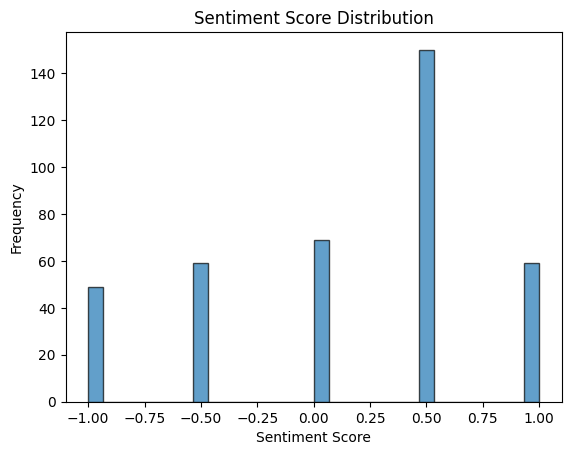

In [6]:
sentiment_data["sentiment"].value_counts()

import matplotlib.pyplot as plt

plt.hist(sentiment_data["sentiment"], bins=30, edgecolor="black", alpha=0.7)
plt.xlabel("Sentiment Score")
plt.ylabel("Frequency")
plt.title("Sentiment Score Distribution")
plt.show()